# 0 Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
from sklearn.model_selection import train_test_split
import torchvision.models as models
import string
import nltk
import math
nltk.download('punkt_tab')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


[nltk_data] Downloading package punkt_tab to /home/white/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# 1 Dataset

In [2]:
captions_file = '../data/train/captions_train.txt'

captions_df = pd.read_table(captions_file, delimiter=',', header=None, names=['image', 'caption'])

captions_df.head()

,image,caption
0,1000092795.jpg,Two young guys with shaggy hair look at their...
1,1000092795.jpg,"Two young , White males are outside near many..."
2,1000092795.jpg,Two men in green shirts are standing in a yard .
3,1000092795.jpg,A man in a blue shirt standing in a garden .
4,1000092795.jpg,Two friends enjoy time spent together .


## 1.1 Dataframe

In [3]:
# Get only unique images
unique_images = captions_df['image'].unique()


# Split images
train_images, test_images = train_test_split(unique_images, test_size=0.2, random_state=42)
train_images, val_images = train_test_split(train_images, test_size=0.1, random_state=42)


# DataFrame creation
train_df = captions_df[captions_df['image'].isin(train_images)].reset_index(drop=True)
train_df = train_df.dropna().reset_index(drop=True)
val_df = captions_df[captions_df['image'].isin(val_images)].reset_index(drop=True)
val_df = val_df.dropna().reset_index(drop=True)
test_df = captions_df[captions_df['image'].isin(test_images)].reset_index(drop=True)
test_df = test_df.dropna().reset_index(drop=True)

print(f"Numero di immagini nel set di addestramento: {len(train_images)}")
print(f"Numero di immagini nel set di validazione: {len(val_images)}")
print(f"Numero di immagini nel set di test: {len(test_images)}")

Numero di immagini nel set di addestramento: 16018
Numero di immagini nel set di validazione: 1780
Numero di immagini nel set di test: 4450


## 1.2 Vocabulary class

In [4]:
class Vocabulary:
    def __init__(self, freq_threshold):
        self.freq_threshold = freq_threshold
        self.word2idx = {'<PAD>': 0, '<START>': 1, '<END>': 2, '<UNK>': 3}
        self.idx2word = {0: '<PAD>', 1: '<START>', 2: '<END>', 3: '<UNK>'}
        self.word_freq = {}
        self.idx = 4
        # self.translator = str.maketrans("","", string.punctuation + string.digits + "\t\r\n")
         

    def __len__(self):
        return len(self.word2idx)

    def tokenize(self, text):
        return nltk.tokenize.word_tokenize(text)

    def build_vocabulary(self, sentence_list):
        for sentence in sentence_list:
            for word in self.tokenize(sentence):
                if word not in self.word_freq:
                    self.word_freq[word] = 1
                else:
                    self.word_freq[word] += 1

                if self.word_freq[word] == self.freq_threshold:
                    self.word2idx[word] = self.idx
                    self.idx2word[self.idx] = word
                    self.idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenize(text)
        return [self.word2idx.get(word, self.word2idx['<UNK>']) for word in tokenized_text]

In [5]:
vocab = Vocabulary(freq_threshold=5)
caption_list = train_df['caption'].tolist()
vocab.build_vocabulary(caption_list)

print(f"Dimensione del vocabolario: {len(vocab)}")

Dimensione del vocabolario: 5900


## 1.3 Glove

In [6]:
def load_glove_embeddings(glove_file):
    embeddings = {}
    with open(glove_file, 'r', encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    print(f"Caricati {len(embeddings)} vettori di embedding da GloVe.")
    return embeddings

# Caricamento degli embeddings GloVe
glove_file = '../glove/glove.6B.100d.txt'
glove_embeddings = load_glove_embeddings(glove_file)

def create_embedding_matrix(vocab, glove_embeddings, embedding_dim):
    vocab_size = len(vocab)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    for word, idx in vocab.word2idx.items():
        if word in glove_embeddings:
            embedding_matrix[idx] = glove_embeddings[word]
        else:
            # Inizializza con un vettore casuale per le parole non trovate
            embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))
    return torch.tensor(embedding_matrix, dtype=torch.float32)

embedding_dim = 100  # Deve corrispondere alla dimensione degli embeddings GloVe scaricati
embedding_matrix = create_embedding_matrix(vocab, glove_embeddings, embedding_dim)

Caricati 400000 vettori di embedding da GloVe.


## 1.4 Dataset class

In [7]:
class FlickrDataset(Dataset):
    def __init__(self, dataframe, image_dir, vocab, transform=None):
        self.image_dir = image_dir
        self.vocab = vocab
        self.transform = transform

        # Creiamo una lista di coppie (immagine, didascalia)
        self.image_ids = []
        self.captions = []

        grouped = dataframe.groupby('image')['caption'].apply(list).reset_index()

        for idx in range(len(grouped)):
            img_id = grouped.loc[idx, 'image']
            captions = grouped.loc[idx, 'caption']
            for cap in captions:
                self.image_ids.append(img_id)
                self.captions.append(cap)

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        caption = self.captions[idx]
        image_id = self.image_ids[idx]
        image_path = os.path.join(self.image_dir, image_id)
        image = Image.open(image_path).convert("RGB")

        if self.transform is not None:
            image = self.transform(image)

        numericalized_caption = [self.vocab.word2idx['<START>']]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.word2idx['<END>'])
        numericalized_caption = torch.tensor(numericalized_caption)

        return image, numericalized_caption

### 1.4.1 Transformation Sequence

In [8]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # Valori standard per ImageNet
        std=[0.229, 0.224, 0.225]
    ),
])

tranf_only_tensor = transforms.Compose([
    transforms.ToTensor()
])

## 1.5 Dataset creation

In [9]:
image_dir = '../data/train'

train_dataset = FlickrDataset(train_df, image_dir, vocab, transform=transform)
val_dataset = FlickrDataset(val_df, image_dir, vocab, transform=transform)
test_dataset = FlickrDataset(test_df, image_dir, vocab, transform=transform)
test_dataset_or = FlickrDataset(test_df, image_dir, vocab, transform=tranf_only_tensor)

In [10]:
def collate_fn(batch):
    images = []
    captions = []
    for img, cap in batch:
        images.append(img)
        captions.append(cap)
    images = torch.stack(images, dim=0)
    captions = nn.utils.rnn.pad_sequence(captions, batch_first=True, padding_value=vocab.word2idx['<PAD>'])
    return images, captions

In [11]:
batch_size = 32

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=collate_fn)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=collate_fn)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=collate_fn)

# 2 Model

## 2.1 Encoder ResNet50

In [12]:
class EncoderCNN(nn.Module):
    def __init__(self, d_model=512):
        super(EncoderCNN, self).__init__()
        self.d_model = d_model
        resnet = models.resnet50(pretrained=True)
        modules = list(resnet.children())[
            :-2
        ]  # Rimuovi gli ultimi due layer (avgpool e fc)
        self.resnet = nn.Sequential(*modules)
        self.conv = nn.Conv2d(
            2048, d_model, kernel_size=1
        )  # Riduce la dimensione delle feature a d_model
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, images):
        # Estrai le feature map
        features = self.resnet(images)  # [batch_size, 2048, H, W]
        features = self.conv(features)  # [batch_size, d_model, H, W]
        features = features.flatten(2)  # [batch_size, d_model, H*W]
        features = features.permute(2, 0, 1)  # [H*W, batch_size, d_model]
        return features  # Sequence length = H*W

## 2.2 Positional Encoding

In [13]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000, dropout=0.1):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
        )

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(1)  # [max_len, 1, d_model]
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[: x.size(0), :]
        return self.dropout(x)

## 2.2 Decoder with Transformer

In [14]:
class DecoderWithTransformer(nn.Module):
    def __init__(self, vocab_size, embedding_matrix, d_model=512, num_heads=8, num_layers=6, dropout=0.1):
        super(DecoderWithTransformer, self).__init__()
        self.d_model = d_model
        embed_size = embedding_matrix.size(1)
        self.embed = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        self.embed_proj = nn.Linear(embed_size, d_model) if embed_size != d_model else nn.Identity()
        self.pos_encoder = PositionalEncoding(d_model, dropout=dropout)

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model, nhead=num_heads, dropout=dropout
        )
        self.transformer_decoder = nn.TransformerDecoder(
            decoder_layer, num_layers=num_layers
        )

        self.fc_out = nn.Linear(d_model, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, tgt, memory):
        tgt_emb = self.embed(tgt)  # [seq_len_tgt, batch_size, embed_size]
        tgt_emb = self.embed_proj(tgt_emb) * math.sqrt(self.d_model)  # [seq_len_tgt, batch_size, d_model]
        tgt_emb = self.pos_encoder(tgt_emb)

        tgt_mask = self.generate_square_subsequent_mask(tgt.size(0)).to(tgt.device)

        output = self.transformer_decoder(tgt_emb, memory, tgt_mask=tgt_mask)
        output = self.fc_out(output)  # [seq_len_tgt, batch_size, vocab_size]
        return output

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = (
            mask.float()
            .masked_fill(mask == 0, float("-inf"))
            .masked_fill(mask == 1, float(0.0))
        )
        return mask
  

In [15]:
vocab_size = len(vocab)
d_model = 512 
num_heads = 8
num_layers = 6

encoder = EncoderCNN(d_model).to(device)
decoder = DecoderWithTransformer(vocab_size, embedding_matrix, d_model, num_heads, num_layers).to(device)

/home/white/miniconda3/envs/dml/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/white/miniconda3/envs/dml/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# 3 Training

In [16]:
learning_rate = 1e-3

## 3.1 Training function

In [17]:
def train_model(encoder, decoder, criterion, optimizer, dataloader, valdataloader, num_epochs):
    train_losses, val_losses = [], []
    
    for epoch in range(num_epochs):
        encoder.train()
        decoder.train()

        # Training phase
        total_train_loss = 0
        for i, (images, captions) in enumerate(dataloader):
            images = images.to(device)
            captions = captions.to(device)

            optimizer.zero_grad()

            # Forward pass
            memory = encoder(images)  # [seq_len_src, batch_size, d_model]

            # Prepare input and target for decoder
            tgt_input = captions[:, :-1].permute(1, 0)  # [seq_len_tgt, batch_size]
            tgt_output = captions[:, 1:].permute(1, 0)  # [seq_len_tgt, batch_size]

            outputs = decoder(tgt_input, memory)  # [seq_len_tgt, batch_size, vocab_size]

            # Loss computation
            loss = criterion(outputs.reshape(-1, outputs.size(-1)), tgt_output.reshape(-1))
            total_train_loss += loss.item()

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            if i % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(dataloader)}], Loss: {loss.item():.4f}")
        
        average_train_loss = total_train_loss / len(dataloader)
        train_losses.append(average_train_loss)

        # Validation phase
        encoder.eval()
        decoder.eval()
        total_val_loss = 0
        with torch.no_grad():
            for i, (images, captions) in enumerate(valdataloader):
                images = images.to(device)
                captions = captions.to(device)

                # Forward pass
                memory = encoder(images)
                tgt_input = captions[:, :-1].permute(1, 0)
                tgt_output = captions[:, 1:].permute(1, 0)
                outputs = decoder(tgt_input, memory)

                # Loss computation
                loss = criterion(outputs.reshape(-1, outputs.size(-1)), tgt_output.reshape(-1))
                total_val_loss += loss.item()

        average_val_loss = total_val_loss / len(valdataloader)
        val_losses.append(average_val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {average_train_loss:.4f}, Validation Loss: {average_val_loss:.4f}")

    return train_losses, val_losses

In [18]:
num_epochs = 10
criterion = nn.CrossEntropyLoss(ignore_index=vocab.word2idx['<PAD>'])
params = list(decoder.parameters()) + list(encoder.parameters())
optimizer = torch.optim.Adam(params, lr=learning_rate)

train_losses, val_losses = train_model(
    encoder, decoder, criterion, optimizer, train_loader, val_loader, num_epochs
)

/home/white/miniconda3/envs/dml/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:84.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch [1/10], Step [0/2503], Loss: 8.8503
Epoch [1/10], Step [100/2503], Loss: 5.6460
Epoch [1/10], Step [200/2503], Loss: 5.5513
Epoch [1/10], Step [300/2503], Loss: 5.4969
Epoch [1/10], Step [400/2503], Loss: 5.5461
Epoch [1/10], Step [500/2503], Loss: 5.5656
Epoch [1/10], Step [600/2503], Loss: 5.4285
Epoch [1/10], Step [700/2503], Loss: 5.5283
Epoch [1/10], Step [800/2503], Loss: 5.5501
Epoch [1/10], Step [900/2503], Loss: 5.6385
Epoch [1/10], Step [1000/2503], Loss: 5.3611
Epoch [1/10], Step [1100/2503], Loss: 5.4195
Epoch [1/10], Step [1200/2503], Loss: 5.6045
Epoch [1/10], Step [1300/2503], Loss: 5.5819
Epoch [1/10], Step [1400/2503], Loss: 5.6169
Epoch [1/10], Step [1500/2503], Loss: 5.6236
Epoch [1/10], Step [1600/2503], Loss: 5.6057
Epoch [1/10], Step [1700/2503], Loss: 5.5295
Epoch [1/10], Step [1800/2503], Loss: 5.4826
Epoch [1/10], Step [1900/2503], Loss: 5.3071
Epoch [1/10], Step [2000/2503], Loss: 5.4761
Epoch [1/10], Step [2100/2503], Loss: 5.4641
Epoch [1/10], Step [22

## 3.2 Visualization

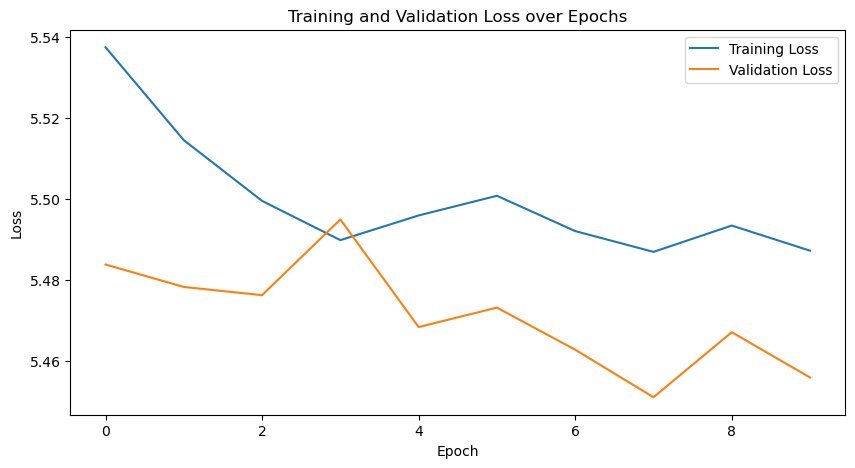

In [22]:
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 4 Caption generation and testing

In [20]:
def generate_caption_beam_search(encoder, decoder, image, vocab, beam_size=3, max_length=20):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        # Preprocessamento dell'immagine
        if len(image.shape) == 3:
            image = image.unsqueeze(0)  # Aggiunge la dimensione batch se necessario
        image = image.to(device)

        # Ottieni le feature dall'encoder
        memory = encoder(image)  # [seq_len_src, batch_size=1, d_model]

        # Inizializza le sequenze di didascalie e punteggi
        sequences = [[vocab.word2idx['<START>']]]
        scores = torch.zeros(1).to(device)

        for _ in range(max_length):
            all_candidates = []
            for i in range(len(sequences)):
                seq = sequences[i]
                score = scores[i]

                tgt_input = torch.tensor(seq).unsqueeze(1).to(device)  # [seq_len_tgt, 1]
                output = decoder(tgt_input, memory)  # [seq_len_tgt, 1, vocab_size]
                output = output[-1, 0, :]  # Prendiamo l'ultimo token
                probs = torch.log_softmax(output, dim=-1)
                top_k_probs, top_k_idx = probs.topk(beam_size)

                for j in range(beam_size):
                    candidate = seq + [top_k_idx[j].item()]
                    candidate_score = score + top_k_probs[j]
                    all_candidates.append((candidate_score, candidate))

            ordered = sorted(all_candidates, key=lambda tup: tup[0], reverse=True)
            sequences = [candidate for _, candidate in ordered[:beam_size]]
            scores = torch.tensor([score for score, _ in ordered[:beam_size]]).to(device)

        # Prendi la sequenza migliore
        best_seq = sequences[0]
        sampled_caption = [vocab.idx2word[idx] for idx in best_seq[1:] if idx != vocab.word2idx['<END>']]
        sentence = ' '.join(sampled_caption)
    return sentence

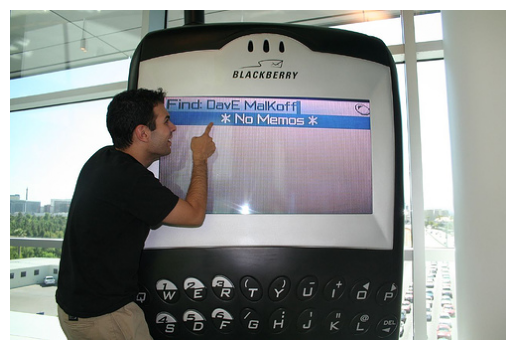

Didascalia Generata: a a a a a a a a a a a a a a a a a a a a


In [35]:
import random

# image picking
idx = random.randint(0, len(test_dataset))
test_image, _ = test_dataset[idx]
print_image, _ = test_dataset_or[idx]
plt.imshow(print_image.permute(1, 2, 0))
plt.axis('off')
plt.show()

# caption generation
caption = generate_caption_beam_search(encoder, decoder, test_image, vocab)
# caption = ' '.join(caption.split()[:-1])
print("Caption:", caption)

In [ ]:
def mean(l): return sum(l)/len(l)

lt = len(train_losses)
lv = len(val_losses)
step = 100
t_l = [mean(train_losses[i:min(i+lt//step, lt)]) for i in range(0, lt, lt//step)]
v_l = [mean(val_losses[i:min(i+lv//step, lv)]) for i in range(0, lv, lv//step)]
plt.figure(figsize=(10,5))
plt.plot(t_l, label='Training Loss')
plt.plot(v_l, label='Validation Loss')
plt.title('ResNet + RNN & Attention -- Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(ticks=range(0, len(t_l), 10), labels=range(0, 11))
plt.legend()
plt.show()
# plt.savefig('../img/resnet_transformer.pdf', format='pdf')

# 5 Chekpoint

In [19]:
# save model
# torch.save(
#     {
#         "encoder_state_dict": encoder.state_dict(),
#         "decoder_state_dict": decoder.state_dict(),
#         "train_losses": train_losses,
#         "val_losses": val_losses,
#     },
#     "../ckpt/resnet_transformer.ckpt",
# )

checkpoint = torch.load("../ckpt/resnet_transformer.ckpt")

encoder = EncoderCNN(d_model).to(device)
encoder.load_state_dict(checkpoint["encoder_state_dict"])
encoder = encoder.to(device)

decoder = DecoderWithTransformer(vocab_size, embedding_matrix, d_model, num_heads, num_layers).to(device)
decoder.load_state_dict(checkpoint["decoder_state_dict"])
decoder = decoder.to(device)

train_losses = checkpoint["train_losses"]
val_losses = checkpoint["val_losses"]